## StackLabs - Health Cross Sell

### Feature Engineering

In [15]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minio                      import Minio
from boruta                     import BorutaPy
from sklearn.tree               import DecisionTreeClassifier
from sklearn.model_selection    import train_test_split,cross_val_predict
from sklearn.preprocessing      import MinMaxScaler,StandardScaler,RobustScaler
from imblearn.over_sampling     import SMOTE
from sklearn.feature_selection  import mutual_info_classif,SelectKBest,f_classif
from sklearn.model_selection    import train_test_split,cross_val_predict
from sklearn.preprocessing      import MinMaxScaler,StandardScaler,RobustScaler
from xgboost                    import XGBClassifier
from category_encoders          import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [16]:
#Converte o tipo de dado para categórico
def conv_cat(df,cols):
    df[cols]=df[cols].astype('category')

In [17]:
data=pd.read_csv('train.csv')

In [18]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


#### Verificando os registros missing.

In [19]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Organizando o dataset.

In [20]:
data=data[['id','Gender','Vehicle_Age','Vehicle_Damage','Region_Code','Policy_Sales_Channel','Driving_License','Previously_Insured',
          'Age','Vintage','Annual_Premium','Response']]

#### Alterando os tipos de dados.

In [21]:
cols=['Gender','Vehicle_Age','Vehicle_Damage','Region_Code','Policy_Sales_Channel']
conv_cat(data,cols)

#### Renomeando atributos

In [22]:
data=data.rename(columns={'Vehicle_Age':'V_age','Vehicle_Damage':'Damage','Region_Code':'Region','Policy_Sales_Channel':'Channel','Driving_License':'License',
                  'Previously_Insured':'Insured','Annual_Premium':'Rate' })

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        381109 non-null  int64   
 1   Gender    381109 non-null  category
 2   V_age     381109 non-null  category
 3   Damage    381109 non-null  category
 4   Region    381109 non-null  category
 5   Channel   381109 non-null  category
 6   License   381109 non-null  int64   
 7   Insured   381109 non-null  int64   
 8   Age       381109 non-null  int64   
 9   Vintage   381109 non-null  int64   
 10  Rate      381109 non-null  float64 
 11  Response  381109 non-null  int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 22.5 MB


In [24]:
data.head()

,id,Gender,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Response
0,1,Male,> 2 Years,Yes,28.0,26.0,1,0,44,217,40454.0,1
1,2,Male,1-2 Year,No,3.0,26.0,1,0,76,183,33536.0,0
2,3,Male,> 2 Years,Yes,28.0,26.0,1,0,47,27,38294.0,1
3,4,Male,< 1 Year,No,11.0,152.0,1,1,21,203,28619.0,0
4,5,Female,< 1 Year,No,41.0,152.0,1,1,29,39,27496.0,0


In [25]:
#removendo coluna id pois não acrescenta informação relevante para o modelo
data.drop(['id'],axis=1,inplace=True)

In [26]:
df=data.copy()

In [27]:
# Utilizando one hot encoder para a coluna gênero
data = pd.get_dummies(data, columns=["Gender"], prefix="Gender")
data

,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Response,Gender_Female,Gender_Male
0,> 2 Years,Yes,28.0,26.0,1,0,44,217,40454.0,1,0,1
1,1-2 Year,No,3.0,26.0,1,0,76,183,33536.0,0,0,1
2,> 2 Years,Yes,28.0,26.0,1,0,47,27,38294.0,1,0,1
3,< 1 Year,No,11.0,152.0,1,1,21,203,28619.0,0,0,1
4,< 1 Year,No,41.0,152.0,1,1,29,39,27496.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,1-2 Year,No,26.0,26.0,1,1,74,88,30170.0,0,0,1
381105,< 1 Year,No,37.0,152.0,1,1,30,131,40016.0,0,0,1
381106,< 1 Year,No,30.0,160.0,1,1,21,161,35118.0,0,0,1
381107,> 2 Years,Yes,14.0,124.0,1,0,68,74,44617.0,0,1,0


In [28]:
channel_counts = dict(data['Channel'].value_counts())

In [29]:
total_rows = data.shape[0]

In [30]:
data['Channel'] = data['Channel'].astype(float)

In [31]:
# Canais de venda com mais incidência tem peso maior
for k,v in channel_counts.items():
    new_value = round(v / total_rows, 3)
    data['Channel'].mask(df['Channel'] == k, new_value, inplace=True)

In [32]:
region_counts = dict(data['Region'].value_counts())

In [33]:
data['Region'] = data['Region'].astype(float)

In [34]:
# Região com mais incidência tem peso maior
for k,v in region_counts.items():
    new_value = round(v / total_rows, 3)
    data['Region'].mask(df['Region'] == k, new_value, inplace=True)

In [35]:
#Codificando variavies categoricas 
data['V_age'] = data['V_age'].map( {'< 1 Year': 0, '1-2 Year': 1,'> 2 Years':2} ).astype(int)
data['Damage'] = data['Damage'].map( {'No': 0,'Yes': 1} ).astype(int)

In [36]:
max_age = data['Age'].max()
max_age

85

In [37]:
# Normalizando coluna de idade
data['Age'] = data['Age'] / max_age

In [38]:
data.head()

,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Response,Gender_Female,Gender_Male
0,2,1,0.279,0.209,1,0,0.517647,217,40454.0,1,0,1
1,1,0,0.024,0.209,1,0,0.894118,183,33536.0,0,0,1
2,2,1,0.279,0.209,1,0,0.552941,27,38294.0,1,0,1
3,0,0,0.024,0.354,1,1,0.247059,203,28619.0,0,0,1
4,0,0,0.048,0.354,1,1,0.341176,39,27496.0,0,1,0


#### Separando os conjuntos de dados.

In [39]:
target_name = 'Response'
X = data.drop('Response', axis=1)
y = data[target_name]

#### Transformando os dados.

In [40]:
#removendo outliers
scaler = RobustScaler()
X['Rate'] = scaler.fit_transform( X[['Rate']].values )

In [41]:
#normalizando os dados
num_feat = ['Age','Vintage','Rate']
mm_scaler= MinMaxScaler()
X[num_feat] = mm_scaler.fit_transform(X[num_feat])

In [42]:
X.head()

,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Gender_Female,Gender_Male
0,2,1,0.279,0.209,1,0,0.369231,0.716263,0.070366,0,1
1,1,0,0.024,0.209,1,0,0.861538,0.598616,0.057496,0,1
2,2,1,0.279,0.209,1,0,0.415385,0.058824,0.066347,0,1
3,0,0,0.024,0.354,1,1,0.015385,0.667820,0.048348,0,1
4,0,0,0.048,0.354,1,1,0.138462,0.100346,0.046259,1,0


In [43]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((266776, 11), (266776,), (114333, 11), (114333,))

#### Feature Importance.

#### DecisionTree Classifier - Feature Selection

In [44]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)

In [45]:
importances = dtree.feature_importances_
feat_names = data.drop(['Response'],axis=1).columns

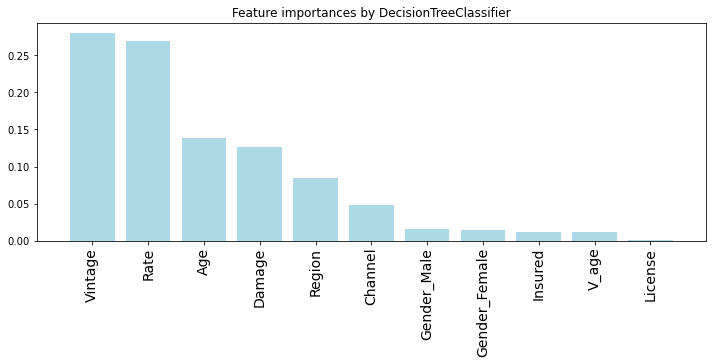

In [46]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Mutual_info_classif - Feature Selection

In [47]:
mutual_info=mutual_info_classif(X_train,y_train)

In [48]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Insured          0.093394
Damage           0.090050
License          0.052409
Channel          0.040970
V_age            0.039746
Age              0.030427
Gender_Male      0.016068
Gender_Female    0.011993
Region           0.010173
Rate             0.003635
Vintage          0.000645
dtype: float64

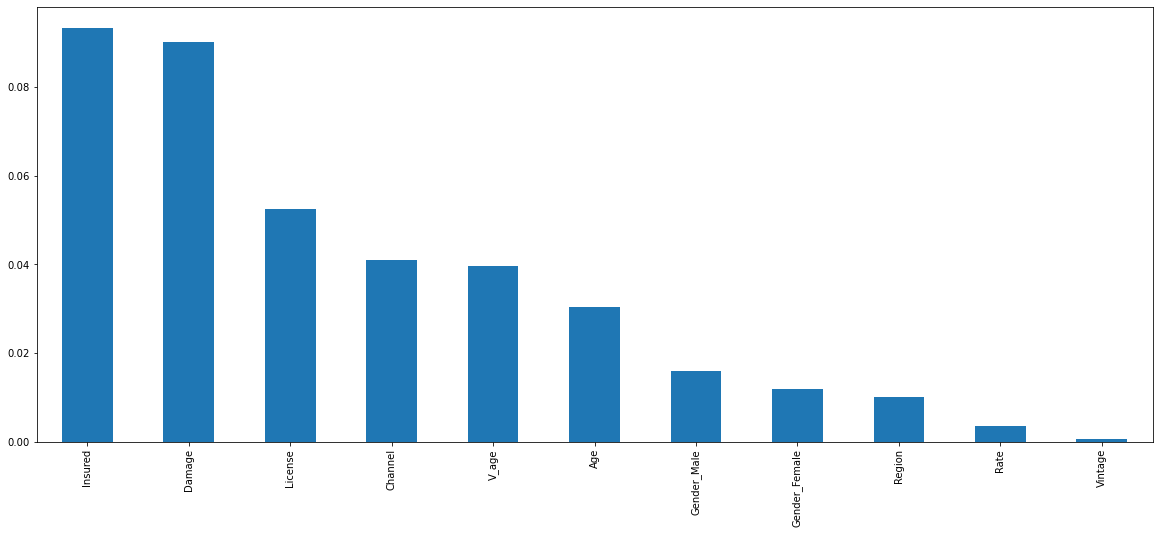

In [49]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8));

In [50]:
k_best_features = SelectKBest(mutual_info_classif, k=8).fit(X_train, y_train)
print('Selected top 8 features: {}'.format(X_train.columns[k_best_features.get_support()]))

Selected top 8 features: Index(['V_age', 'Damage', 'Channel', 'License', 'Insured', 'Age',
       'Gender_Female', 'Gender_Male'],
      dtype='object')


In [54]:
data.head()

,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Response,Gender_Female,Gender_Male
0,2,1,0.279,0.209,1,0,0.517647,217,40454.0,1,0,1
1,1,0,0.024,0.209,1,0,0.894118,183,33536.0,0,0,1
2,2,1,0.279,0.209,1,0,0.552941,27,38294.0,1,0,1
3,0,0,0.024,0.354,1,1,0.247059,203,28619.0,0,0,1
4,0,0,0.048,0.354,1,1,0.341176,39,27496.0,0,1,0


#### Exportando o conjunto de dados para o disco.

In [55]:
data.to_csv("health.csv",index=False)